## Post Spike Sorting Data Preparation
1. Select time points for analysis with plot iterface: chose the BW and threshold by hand to select times of activity.
2. Generates Data Frames with spike arrival times and stim
3. Also plots filtered raw trace for checking.

##### Note that after spike sorting and before running this GUI you must make a map that will merge the signals from different sessions
`luigi --module preprocess_ephys MergeLazySignals --site SITE_DIR --local-scheduler`

##### Note also that this code requires the songephys code; run it after activating that environment.

##### You should only have to change the root path AND the electrode reference (below in cell #2 after Set Paths) for this GUI to work

#### After running this step you can visualize PSHTs using PlotPSTHCategoriesGUI

### Dependencies

In [1]:
# Core packages (Needs songephys environment)
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk

# Data Processing Stuff
from sklearn.neighbors import KernelDensity
from scipy.io import wavfile

# Display and GUI
import ipywidgets as widgets


# Theunissen Lab Code
import suss.io
from analysis.playbacks.categories import create_stimulus_dataframe, inject_spikes, relative_spike_times


### Set Paths
Note that it is assumed that you have data directory accessible from the rootPath

In [2]:
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'
elecReference = 8        # This number should be 8 for 16 electrode configuration and 0 for 32 electrode configuration

birds = [
    os.path.basename(bird)
    for bird in sorted(glob.glob(os.path.join(rootPath+dataPath, "*")), key=os.path.getmtime, reverse=True)
    if (os.path.isdir(bird))]

### Define Input Widgets

In [3]:
# Widget to pick bird
bird_picker = widgets.Dropdown(
    options=birds,
    value=birds[0],
    description="Bird",
    disabled=False,
)

site_picker = widgets.Dropdown(
    options=['None'],
    value='None',
    description="Site",
    disabled=False
)

electrode_picker = widgets.Dropdown(
    options=['None'],
    value='None',
    description="Electrode",
    disabled=False
)

cluster_picker = widgets.Dropdown(
    options=['None'],
    value='None',
    description="Cluster",
    disabled=False
)

threshold_picker = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=10.0,
    step=0.1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

bandWidth_picker = widgets.FloatSlider(
    value=5.0,
    min=0.2,
    max=10.0,
    step=0.1,
    description='KDE BW:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

save_button = widgets.Button(
    description='Save',
    disabled=False,
    button_style='success', 
    tooltip='Click me to save',
    icon='check' 
)

time_picker = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=100.0,
    step=1,
    description='Start:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

duration_picker = widgets.FloatSlider(
    value=1.0,
    min=0.1,
    max=10.0,
    step=0.1,
    description='Duration:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)




### Loading Functions

In [4]:
def load_bird(change):
    
    bird = change['new']
    if bird is not load_bird._loaded[0]:
        sites = [ 
            os.path.basename(site)
            for site in glob.glob(os.path.join(rootPath+dataPath+bird+'/sites/', "*"))
            ]

        load_bird._loaded = (bird, 'None', 'None', 'None')
        site_picker.options=['None'] + sites
        site_picker.value='None'
        electrode_picker.options=['None'] 
        electrode_picker.value='None'
        cluster_picker.options=['None'] 
        cluster_picker.value='None'
        
        
    return load_bird._loaded


def load_site(change):

    global eventsPath, rawPath, events, lazy_data    
    
    bird = bird_picker.value
    site = change['new']
    if (bird, site) is not (load_site._loaded[0],load_site._loaded[1]):
        if site != 'None' and site is not None:
            # Set Paths
            eventsPath = rootPath + dataPath + bird + '/sites/' + site + '/vocal_periods.npy'
            rawPath = rootPath + dataPath + bird + '/sites/' + site

            # Load Acoustic events
            events = np.load(eventsPath, allow_pickle=True)[()]

            # Lazy load the raw data
            lazy_data = np.load(os.path.join(rawPath, "lazy.npy"), allow_pickle=True)[()]
    
            # Set up electrodes
            electrodes = [ 
                int(re.match('curated-e(\d+).pkl',os.path.basename(efile)).groups()[0])
                for efile in glob.glob(os.path.join(rootPath+dataPath+bird+'/sites/'+ site + '/manually_curated/', "curated-*.pkl"))
                if re.match('curated-e(\d+).pkl',os.path.basename(efile))
            ]
            electrodes.sort()
            electrode_picker.options=['None']+electrodes 
        else:
            eventsPath = None
            rawPath = None
            events = None
            lazy_data = None
            electrode_picker.options=['None']
            
        electrode_picker.value='None'
        cluster_picker.options=['None'] 
        cluster_picker.value='None'

        load_site._loaded = (bird, site, 'None', 'None')
    
    return load_site._loaded
    
def load_electrode(change):
    global spikesPath, spike_file
    
    bird = bird_picker.value
    site = site_picker.value
    electrode = change['new']
    if (bird, site, electrode) is not (load_electrode._loaded[0],load_electrode._loaded[1],load_electrode._loaded[2]) :
        
        if electrode != 'None' and electrode is not None:
            # Set Paths
            spikesPath = rootPath + dataPath + bird + '/sites/' + site + '/manually_curated/curated-e' + str(electrode) + '.pkl'

            # Load spike data and get a list of clusters
            spike_file = suss.io.read_pickle(spikesPath)
            labeled_nodes_dict = dict(spike_file.labeled_nodes)
            clusters = list(labeled_nodes_dict.keys())        
            cluster_picker.options=['None']+clusters
        else:
            spikesPath = None
            spike_file = None
            cluster_picker.options=['None']
        
        cluster_picker.value='None'        
        load_electrode._loaded = (bird, site, electrode, 'None')
        
    return load_electrode._loaded

def load_cluster(change):
    global outPath, spikeTimes, spikeWaveforms, df
    
    bird = bird_picker.value
    site = site_picker.value
    electrode = electrode_picker.value
    cluster = change['new']
    
    if (bird, site, electrode, cluster) is not load_cluster._loaded:
        
        if cluster != 'None' and cluster is not None:
            outDir = rootPath + dataPath + bird + '/sites/' + site + '/PlaybackPkl'
            if not os.path.exists(outDir):
               os.mkdir(outDir)
            outPath =  outDir + '/goodPlayback-e' + str(electrode) + '-c' + str(cluster) + '.pkl'
        
            labeled_nodes_dict = dict(spike_file.labeled_nodes)
            spikes = labeled_nodes_dict[cluster]
            spikeTimes = spikes.flatten().times.reshape(-1,1)
            spikeWaveforms = spikes.flatten().waveforms
            df = create_stimulus_dataframe(events["playback"])
            df = inject_spikes(df, spikeTimes.flatten(), t_buffer=10)
        
            time_picker.max = np.fix(spikeTimes[-1]+2)
        else:
            outPath = None
            spikeTimes = None
            df = None
            
        
        load_cluster._loaded = (bird, site, electrode, cluster)
                    
    
    return load_cluster._loaded

### Initializations and defining some interactions with observe

In [5]:

load_bird._loaded = ('None', 'None', 'None', 'None')
load_site._loaded = ('None', 'None', 'None', 'None')
load_electrode._loaded = ('None', 'None', 'None', 'None')
load_cluster._loaded = ('None', 'None', 'None', 'None')

load_bird({'type' : 'change', 'new': birds[0], 'old': 'None'} )
bird_picker.observe(load_bird, 'value')
site_picker.observe(load_site, 'value')
electrode_picker.observe(load_electrode, 'value')
cluster_picker.observe(load_cluster, 'value')

### Plotting Functions

In [6]:
# This is an output widget used int the plot_zoom function
SNR_output = widgets.Output()

def plot_rate(cluster, rateThresh, bandWidth):
    
    global spikeTimes, df, X_anal, X_good
    
    if cluster == 'None':
        print('Cluster is not defined')
        return
    
    # Find maximum and minum times in events.
    tBeg = np.min(df[['start_time']])
    tEnd = np.max(df[['start_time']])
    # Generate a continuous spike rate with a wide filter
    kde = KernelDensity(kernel='gaussian', bandwidth=bandWidth).fit(spikeTimes)

    tStart = np.fix(spikeTimes[0]-2)
    tEnd = np.fix(spikeTimes[-1]+2)
    npts = int(tEnd-tStart)+1

    X_anal = np.linspace(np.reshape(tStart, (1,)), np.reshape(tEnd, (1,)), npts)

    spikeDens = np.exp(kde.score_samples(X_anal))
    spikeDens = spikeDens*len(spikeTimes)/sum(spikeDens) 


    plt.plot(X_anal, spikeDens)
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Rate (spikes/s)')

    # Put a threshold for rate above rateThres in spikes/s
    X_good = spikeDens > rateThresh
    timeGood = np.array(X_good, dtype = 'int16')*rateThresh
    plt.plot(X_anal, timeGood, 'r')
    plt.show()

def plot_zoom(cluster, startTime, duration):

    global spikeTimes, lazy_data, df
    global spikeWaveMean, spikeWaveStd, spikeSNR
    
    if cluster == 'None':
        print('Cluster is not defined')
        return
        
    timeVal = startTime
    tInt = duration
    
    # These were for the kde which I deleted.

    # sampRate = 1000.0
    # kWidth = 0.03
    # npts = int(tInt*sampRate)+1
    colorPlot = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
    
    # This line will depend on the configuration 
    elecnum = int(load_cluster._loaded[2]) - elecReference
    
    # Get the local spikes, the filtered waveform, and intan sampling interval
    pltSpikes = np.argwhere((spikeTimes.flatten() >= timeVal) & (spikeTimes.flatten() < (timeVal + tInt))).flatten()
    localSpikes = spikeTimes.flatten()[pltSpikes]
    
    d = lazy_data.time_slice(timeVal, timeVal+tInt, signal="filtered")
    intan_dt = d.t[1]-d.t[0]
    
    
    # Set up the plots
    zoomFig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
    
    # Plot raw waveform
    a0.plot(d.t, d.data[:,elecnum])   

    # Plot the KDE and spikes
    if (len(localSpikes)):
        # Generate a rate curve using kde
        #kdeLocal = KernelDensity(kernel='gaussian', bandwidth=kWidth).fit(localSpikes.reshape(-1,1))
        #tRate = np.linspace(timeVal, timeVal+tInt, npts).reshape(-1, 1)
        #localSpikeDens = np.exp(kdeLocal.score_samples(tRate))
        #localSpikeDens = localSpikeDens*len(localSpikes)*sampRate/(sum(localSpikeDens)*tInt)
       
        # Plot rate and spike arrival times        
        #a1.plot(tRate, localSpikeDens)
        maxVal = max(d.data[:,elecnum])
        for icolor, tval in enumerate(localSpikes):
            a0.plot([tval, tval], [0, 0.8*maxVal], color=colorPlot[icolor%8])
    # else:
        # a1.plot([timeVal, timeVal+tInt], [0, 0])
        
    plt.xlabel('Time (s)')
    plt.ylabel('uV')
    ylim = a0.get_ylim()
    
    # Plot Spike Waveforms
    nt = spikeWaveforms.shape[1]
    tSpike = range(nt)*intan_dt
    
    # This is calculated here and stored on save
    spikeWaveMean = np.mean(spikeWaveforms, axis=0)
    spikeWaveStd = np.std(spikeWaveforms, axis=0)
    spikeSNR = (np.max(spikeWaveMean) - np.min(spikeWaveMean)) / np.mean(spikeWaveStd)
    
    SNR_output.clear_output()
    with SNR_output:
        print('Spike Shape SNR %.2f' % spikeSNR)
    
    a1.plot(tSpike*1000.0, spikeWaveMean, '-', color='gray')
    a1.fill_between(tSpike*1000.0, spikeWaveMean - spikeWaveStd, spikeWaveMean + spikeWaveStd,
                 color='gray', alpha=0.2) 
    for icolor, ispike in enumerate(pltSpikes):
        a1.plot(tSpike*1000.0, spikeWaveforms[ispike], color=colorPlot[icolor%8] )
    a1.set_ylim(*ylim)
    plt.xlabel('Time (ms)')
    # plt.ylabel('uV')

    plt.show()
    
 

    
  

### Output Widget

In [7]:
# Widget to plot rate with a given threhold
rate_plot = widgets.interactive_output(
    plot_rate, 
    {
        "cluster" : cluster_picker,
        "rateThresh": threshold_picker,
        "bandWidth": bandWidth_picker,
    }
)

zoom_plot = widgets.interactive_output(
    plot_zoom, 
    {
        "cluster" : cluster_picker,
        "startTime" : time_picker,
        "duration": duration_picker
    }
)

save_output = widgets.Output()



### Saving function

In [8]:
def save_results(b):
    global df, lazy_data, X_anal, X_good
    global spikeWaveMean, spikeWaveStd, spikeSNR
    
    # Parameters to generate a PSTH
    tBef = 0.5   # Time before stim in PSTH
    tInt = 5.0   # Total time in PSHT
    sampRate = 1000.0  # Sampling rate of mean rate
    kWidth = 0.1  # Kernel bandwidth in s for PSTH per trial
    
    # Check to make sure we loaded data
    cluster = load_cluster._loaded[3]    
    if cluster == 'None':
        with save_output:
            print('Nothing to save')
        return

    # Find the location of good stims
    ngoodStim = 0
    df['On'] = False
    goodStims = []
    for ind in df.index:
        st = df.loc[ind,'start_time']
        if ( np.fix(st) in X_anal[X_good]):
            # print('Good Stim at index', ind, 'Stim', df['call_type'][ind])
            ngoodStim = ngoodStim + 1
            df.loc[ind,'On'] = True
            goodStims.append({'ind': ind, 'stimName': df.loc[ind,'file'], 'stimType': df.loc[ind, 'call_type']})
        
    # print('Cell with good responses for', ngoodStim, 'stimuli')

    allStims = np.array([x['stimName'] for x in goodStims])
    uniqueStims, uniqueInd, uniqueCounts = np.unique(allStims, return_inverse=True, return_counts=True)

    nUniqueStims = len(uniqueStims)
    # print('Number of unique stimuli', nUniqueStims)

    # Generate the dictionary of unitInfo
    unitInfo = {'Bird': load_cluster._loaded[0], 'Site': load_cluster._loaded[1], 
            'Electrode': load_cluster._loaded[2], 'Sort': load_cluster._loaded[3], 
            'RateThreshold': threshold_picker.value, 'KDE_BW': bandWidth_picker.value,
            'nStim': nUniqueStims, 'StimName': uniqueStims, 'nTrials': uniqueCounts,
               'SpikeShape': spikeWaveMean, 'SpikeStd': spikeWaveStd, 'SpikeSNR': spikeSNR }

    # Make a data frame with the good rows.
    dfAbsTime = df[df['On']]


    # Now we make a relative time data frame
    dfRelTime = pd.DataFrame(columns=['file', 'relation_short', 'call_type', 
                                  'nTrials', 'trialInd', 
                                  'tStim', 'stimWav', 'micWav',
                                  'spikeTimes', 'tKDE', 'spikeKDE'])
                         
    npts = int(tInt*sampRate)+1

    for iUnique in range(len(uniqueStims)):
        localSpikes = []
        micWav = []
        startTimes = []
        trialInd = []
        nTrials = uniqueCounts[iUnique]
        indTrials = np.argwhere(uniqueInd == iUnique).ravel()

        for iTrial in indTrials:
            # Recover the index in the original data frame
            ind = goodStims[iTrial]['ind']
            trialInd.append(ind)
            # Find the spike trial
            tStart = df.loc[ind, 'start_time']
            startTimes.append(tStart)
            timeVal = tStart - tBef
            localSpikes.append(spikeTimes[(spikeTimes >= timeVal) & (spikeTimes < (timeVal + tInt))]-tStart)
          
            soundFileName = rootPath + df.loc[ind,'file_path']
            # print('Trial', it, 'File', soundFileName)
            # Read the sound file when iTrial is zero
            if iTrial == indTrials[0]:            
                fs , soundStim = wavfile.read(soundFileName)
                soundLen = soundStim.size
                silBef = np.zeros((int(fs*tBef),))
        
                # Pad with zeros if needed
                nAft = int(fs*tInt) - int(fs*tBef) - soundLen
                if nAft >0:
                    silAft = np.zeros(nAft,)
                    soundAll = np.concatenate((silBef, soundStim, silAft))
                else:              
                    soundStim = soundStim[0:nAft-1]
                    soundAll = np.concatenate((silBef, soundStim))
            
                tSound = np.linspace(-tBef, tInt-tBef-1/fs, soundAll.size)
            
        
            # Get the microphone data
            mic = lazy_data.time_slice(timeVal, timeVal+tInt, signal="mic")
            micSig = mic.data[:,0]- mic.data[:,0].mean()
            micWav.append(micSig)
            
            # Get a time value for the mic data as well (in case stim and mic have different sampling rates)
            if iTrial == indTrials[0]:
                tMic = mic.t-timeVal-tBef
        
        # Time for KDE
        tRate = np.linspace(-tBef, tInt-tBef, npts).reshape(-1,1)
            
        # Local KDE
        allSpikes = np.concatenate(localSpikes).reshape(-1,1)
        if (len(allSpikes) == 0):
            localSpikeDens = np.zeros(tRate.shape)            
        else:            
            kdeLocal = KernelDensity(kernel='gaussian', bandwidth=kWidth/nTrials).fit(allSpikes)
    
            # Generate the kde rate.        
            localSpikeDens = np.exp(kdeLocal.score_samples(tRate))
            localSpikeDens = localSpikeDens*len(allSpikes)*sampRate/(sum(localSpikeDens)*nTrials)
    
        # Generate the pandas data frame
        ind = goodStims[indTrials[0]]['ind']
        dfRelTime = dfRelTime.append({'file': df.loc[ind]['file'], 
                                  'relation_short': df.loc[ind]['relation_short'], 
                                  'call_type': df.loc[ind]['call_type'], 
                                  'nTrials' : nTrials, 
                                  'trialInd': trialInd, 
                                  'tStim' : tSound,
                                  'stimWav': soundAll,
                                  'tMic': tMic,
                                  'micWav': micWav,
                                  'spikeTimes': localSpikes,
                                  'tKDE': tRate.ravel(),
                                  'spikeKDE': localSpikeDens}, ignore_index = True)

    # Writeout the results
    fileOut = open(outPath,"wb")
    pk.dump(unitInfo, fileOut)
    pk.dump(dfAbsTime, fileOut)
    pk.dump(dfRelTime, fileOut)
    fileOut.close()
    
    with save_output:
        print('Saved file: '+outPath)

    

In [9]:
save_button.on_click(save_results)

### Run Gui

In [10]:
widgets.VBox([
    widgets.HBox([widgets.VBox([
        bird_picker,
        site_picker,
        electrode_picker,
        cluster_picker,
        threshold_picker,
        bandWidth_picker        
    ]), rate_plot ]),
    widgets.HBox([widgets.VBox([
        time_picker,
        duration_picker,
        SNR_output
    ]), zoom_plot ]),
    save_button,
    save_output

])

In [32]:
tgaps = []
trecs = []

tbeggap = 0
tbegrec = 0
prev = False
for i, val in enumerate(X_good):
    if val & ~prev:   # Step on
        prev = True
        dt = i - tbeggap
        tbegrec = i
        if dt:
           tgaps.append(dt)
    elif ~val & prev: # Step off
        prev = False
        dt = i - tbegrec
        if dt:
            trecs.append(dt)
        tbeggap = i

i +=1
if prev:
   trecs.append(i-tbegrec)
else :
   tgaps.append(i-tbeggap)

sum(trecs) + sum(tgaps)
print(len(X_good))

In [16]:
time_start = 10000
time_end = 10005
dRaw = lazy_data.time_slice(time_start, time_end, signal="raw")
dFilt = lazy_data.time_slice(time_start, time_end, signal="filtered")

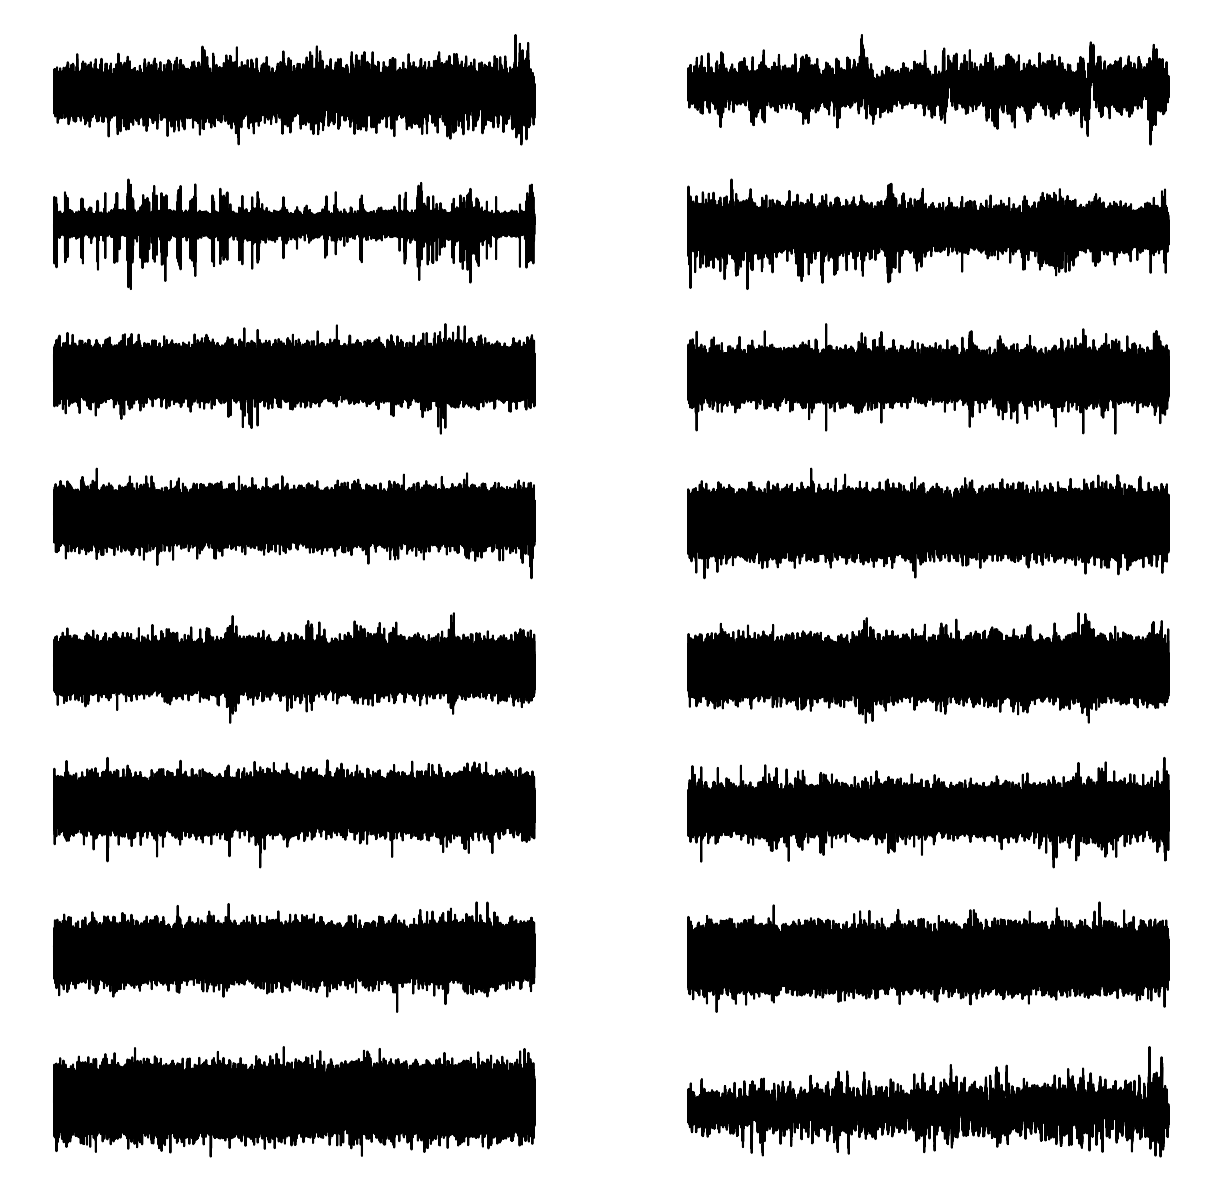

In [17]:
plt.figure(figsize=(5,5), dpi=300)
for i in range(16):
    plt.subplot(8,2,i+1)
    plt.plot(dRaw.data[:,i], 'k', linewidth=0.5)
    #plt.plot(dFilt.data[:,i], 'g', linewidth=0.5)
    plt.axis('off')